In [195]:
import os
os.environ['PATH'] = os.environ['PATH']

In [196]:
import jax
import jax.numpy as jnp
import jax.flatten_util
import optax
import matplotlib.pyplot as plt

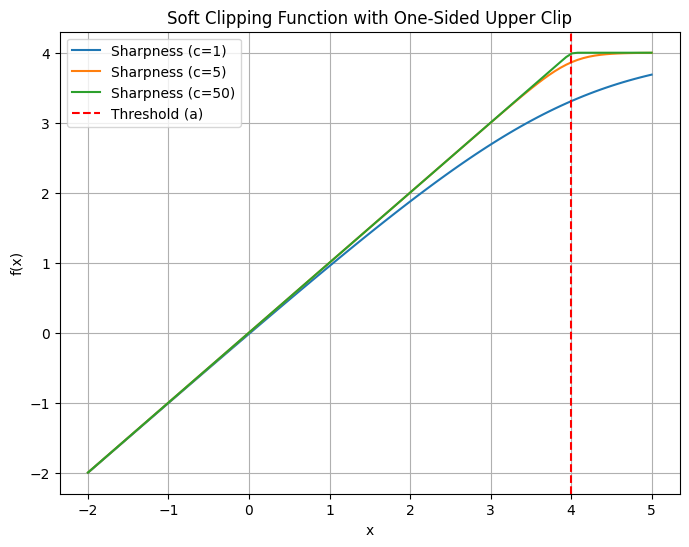

In [197]:
import numpy as np
import matplotlib.pyplot as plt

# Soft clip function (one-sided above)
def soft_clip(x, a, c):
    return x - (1/c) * np.log(1 + np.exp(c * (x - a)))

# Generate a range of x values
x = np.linspace(-2, 5, 100)
a = 4.0  # Clipping threshold
c_values = [1, 5, 50]  # Different sharpness values for control

# Plot for different sharpness values (c)
plt.figure(figsize=(8, 6))
for c in c_values:
    y = soft_clip(x, a, c)
    plt.plot(x, y, label=f'Sharpness (c={c})')

# Plot the threshold line for reference
plt.axvline(x=a, color='red', linestyle='--', label='Threshold (a)')
plt.title('Soft Clipping Function with One-Sided Upper Clip')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

In [198]:
# ----------------------
# Soft Gradient Clipping
# ----------------------
def soft_clip_norm(threshold: float, sharpness: float):
    """Applies a soft gradient norm clipping transformation."""
    def update_fn(updates, state, _):
        # Flatten the gradient updates
        grads_flat, unravel_fn = jax.flatten_util.ravel_pytree(updates)

        # Compute L2 norm
        grad_norm = jnp.linalg.norm(grads_flat)

        # Apply soft clipping
        clipped_norm = grad_norm - jax.nn.softplus(sharpness * (grad_norm - threshold)) / sharpness

        # Compute scale factor
        scale = clipped_norm / (grad_norm + 1e-6)
        print(scale)

        # Scale the updates
        updates_scaled = jax.tree_util.tree_map(lambda g: g * scale, updates)

        return updates_scaled, state

    return optax.GradientTransformation(lambda _: (), update_fn)

In [199]:
# ----------------------
# Model & Loss Function
# ----------------------
def loss_fn(params, x, y):
    """Mean squared error loss."""
    pred = params["w"] * x + params["b"]
    return jnp.mean((pred - y) ** 2)

# ----------------------
# Training Loop
# ----------------------
def train(optimizer, params, opt_state, num_epochs=50):
    """Train the model and collect loss & gradient norm data."""
    loss_history = []
    grad_norm_history = []
    clipped_history = []

    # @jax.jit
    def train_step(params, opt_state, x, y):
        loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        # print(updates)
        new_params = optax.apply_updates(params, updates)

        # Compute gradient norms
        grad_norm = jnp.linalg.norm(jax.flatten_util.ravel_pytree(grads)[0])
        clipped_norm = jnp.linalg.norm(jax.flatten_util.ravel_pytree(updates)[0])

        return new_params, opt_state, loss, grad_norm, clipped_norm

    for epoch in range(num_epochs):
        params, opt_state, loss, grad_norm, clipped_norm = train_step(params, opt_state, x_data, y_data)
        loss_history.append(loss)
        grad_norm_history.append(grad_norm)
        clipped_history.append(clipped_norm)

    return loss_history, grad_norm_history, clipped_history

In [200]:
# ----------------------
# Experiment: SGD + Soft Clipping
# ----------------------
x_data = jnp.array([1.0, 2.0, 3.0])
y_data = jnp.array([2.0, 4.0, 6.0])  # y = 2x (perfect linear function)

threshold = 3.0
sharpness = 10.0
num_epochs = 100

In [201]:

# SGD with Soft Clipping
params_sgd = {"w": jnp.array(3.0), "b": jnp.array(0.0)}
optimizer_sgd = optax.chain(soft_clip_norm(threshold, sharpness), optax.sgd(learning_rate=0.1))
opt_state_sgd = optimizer_sgd.init(params_sgd)

loss_sgd, grad_sgd, clipped_sgd = train(optimizer_sgd, params_sgd, opt_state_sgd, num_epochs)
clipped_sgd  = [x / 0.1 for x in clipped_sgd]


0.29543942
0.43944132
0.8569721
0.99999493
0.9999893
0.99998873
0.9999885
0.9999882
0.9999879
0.9999876
0.9999873
0.999987
0.99998665
0.99998635
0.999986
0.99998564
0.9999853
0.9999849
0.99998456
0.9999842
0.9999838
0.9999834
0.99998295
0.99998254
0.9999821
0.9999817
0.9999812
0.9999808
0.99998033
0.9999798
0.9999793
0.99997884
0.9999783
0.99997777
0.99997723
0.99997663
0.9999761
0.9999755
0.9999749
0.99997425
0.99997365
0.999973
0.9999723
0.9999716
0.9999709
0.9999702
0.9999695
0.9999687
0.9999679
0.9999671
0.9999663
0.9999655
0.9999646
0.99996376
0.99996287
0.9999619
0.999961
0.99996006
0.99995905
0.99995804
0.999957
0.99995595
0.9999549
0.99995375
0.9999526
0.9999515
0.99995023
0.99994904
0.9999478
0.9999465
0.99994516
0.99994385
0.9999424
0.99994105
0.99993956
0.9999381
0.9999366
0.999935
0.9999334
0.99993175
0.9999301
0.99992836
0.99992657
0.9999248
0.99992293
0.999921
0.99991906
0.9999171
0.99991506
0.999913
0.99991083
0.9999086
0.99990636
0.99990404
0.9999017
0.99989927
0.999896

In [202]:
# ----------------------
# Experiment: Adam + Soft Clipping
# ----------------------
params_adam = {"w": jnp.array(3.0), "b": jnp.array(0.0)}
optimizer_adam = optax.chain(soft_clip_norm(threshold, sharpness), optax.adam(learning_rate=0.1))
opt_state_adam = optimizer_adam.init(params_adam)

loss_adam, grad_adam, clipped_adam = train(optimizer_adam, params_adam, opt_state_adam, num_epochs)



0.29543942
0.34512374
0.41488755
0.5199742
0.696249
0.9929575
0.99999934
0.9999945
0.9999992
0.9999901
0.9972791
0.9757014
0.97840774
0.99714535
0.9999429
0.99999917
0.9999992
0.9999983
0.9999939
0.9999984
0.9999991
0.99999934
0.99999934
0.9999992
0.99999934
0.99999934
0.9999992
0.9999989
0.9999983
0.99999577
0.9999945
0.9999978
0.9999985
0.9999988
0.99999887
0.99999887
0.99999875
0.9999985
0.9999979
0.9999964
0.99998957
0.99999434
0.999997
0.99999785
0.99999815
0.9999983
0.9999982
0.999998
0.9999974
0.9999961
0.99999225
0.999982
0.99999315
0.99999577
0.99999654
0.99999684
0.9999967
0.99999624
0.9999952
0.99999225
0.9999799
0.9999822
0.99999183
0.9999943
0.9999952
0.99999535
0.99999505
0.99999404
0.9999918
0.9999852
0.9999494
0.999978
0.9999882
0.99999106
0.9999919
0.99999166
0.9999902
0.9999865
0.9999753
0.9998916
0.99996734
0.9999825
0.99998665
0.9999879
0.9999875
0.9999853
0.99997973
0.99996233
0.9997457
0.99994785
0.9999724
0.9999788
0.9999804
0.99997914
0.9999744
0.9999616
0.99990

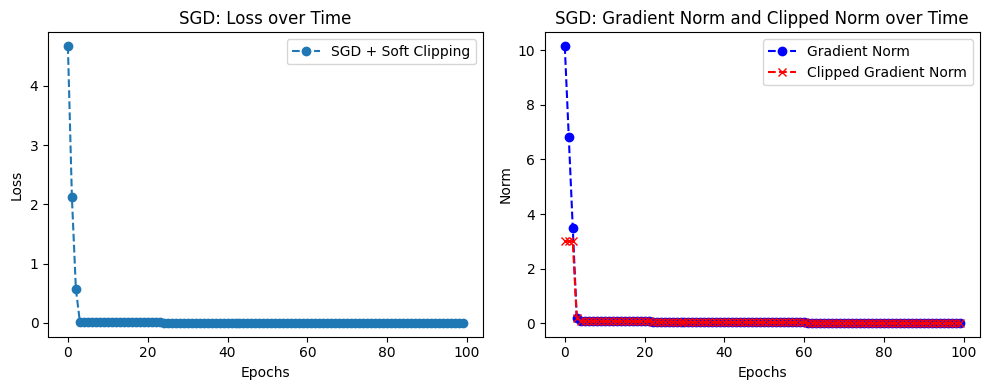

In [203]:
plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_sgd, label="SGD + Soft Clipping", linestyle="--", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SGD: Loss over Time")
plt.legend()

# Gradient norm plot
plt.subplot(1, 2, 2)
plt.plot(grad_sgd, label="Gradient Norm", linestyle="--", marker="o", color='blue')
plt.plot(clipped_sgd, label="Clipped Gradient Norm", linestyle="--", marker="x", color='red')
plt.xlabel("Epochs")
plt.ylabel("Norm")
plt.title("SGD: Gradient Norm and Clipped Norm over Time")
plt.legend()

plt.tight_layout()
plt.show()

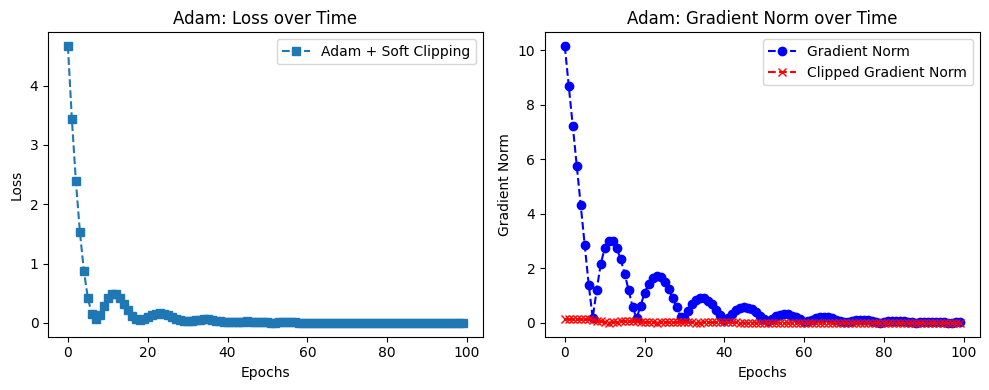

In [204]:
plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_adam, label="Adam + Soft Clipping", linestyle="--", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Adam: Loss over Time")
plt.legend()

# Gradient norm plot
plt.subplot(1, 2, 2)
plt.plot(grad_adam, label="Gradient Norm", linestyle="--", marker="o", color='blue')
plt.plot(clipped_adam, label="Clipped Gradient Norm", linestyle="--", marker="x", color='red')
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm")
plt.title("Adam: Gradient Norm over Time")
plt.legend()

plt.tight_layout()
plt.show()